In [343]:
from pure_functions import W_pred, corr_func, L_pred, smoother, solub, final_value, SED, file_finder
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


In [468]:
class DataManager:
    def __init__(self, omni_filename="expttsd", imed_filename="imed"):
        self.omni_filename  = "expttsd"
        self.imed_filename  = "imed"
        self.omni_folder    = None
        self.DESC_best_W    = [2]
        self.DESC_best      = [1, 2]
        self.finaltime      = 10 # minutes
        self.colors         = ['orange','magenta','blue','red','green']
        self.conc_corr      = True
        self.sizedata       = []
        self.EVAL           = []
        self.popt           = [1,0]
        self.read_files     = []
        self.read_data_from = []
        
    def plot_generator(self):
        
        if not self.EVAL:
            pass

        else:
            mpl.rcParams.update({'font.size': 9,'axes.labelsize': 9,'axes.titlesize': 9,'xtick.labelsize': 9,'ytick.labelsize': 9,'legend.fontsize': 9,
                             'grid.alpha': 0.5, 'grid.linewidth': 0.7,'grid.linestyle': '-', 'xtick.minor.visible': True,
                             'ytick.minor.visible': True,})
        
            mpl.rcParams['xtick.minor.visible'] = True
            mpl.rcParams['ytick.minor.visible'] = True
            
            NBINS = 4
        
            self.fig, self.axT = plt.subplots(len(self.EVAL)+1,4,figsize=(10,1.5*(len(self.EVAL)+1)))
            
            for i in range(len(self.EVAL)):
                E = self.EVAL[i]
                T1, WWW_1, LLL_1, SL1, SW1 = self.data_evaluator(E,70)
                                
                if len(T1) != 0:
                    
                    self.axT[i,0].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                    self.axT[i,0].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                    self.axT[i,0].set_ylabel(E.columns[2][0]+'\n'+'['+self.EVAL[i].columns[2][1]+']')
                    self.axT[i,0].yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,0].xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,0].grid(which='major', alpha=0.2) 
                    self.axT[i,0].grid(which='minor', alpha=0.075)  
                    
                    if 'OPC R: Counts ' in self.EVAL[i].columns:
                        ax_FBRM = self.axT[i,0].twinx()
                        ax_FBRM.plot(T1,self.EVAL[i]['OPC R: Counts '],self.colors[i%5],linestyle='-',alpha=0.7)
                        ax_FBRM.yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_FBRM.xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_FBRM.tick_params(axis='y', colors=self.colors[i % 5])
                        ax_FBRM.spines['right'].set_color(self.colors[i%5])
                        ax_FBRM.set_ylabel(E.columns[4][0]+'\n'+'['+self.EVAL[i].columns[4][1]+']',color=self.colors[i%5])
                        ax_FBRM.set_ylim([0,80000])
                    else:
                        self.axT[i,0].text(self.axT[i,0].get_xlim()[1]*(0.3),self.axT[i,0].get_ylim()[1]*0.8,f'No counts data', color=self.colors[i%5])
                    
                    self.axT[i,1].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                    self.axT[i,1].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                    self.axT[i,1].set_ylabel(E.columns[2][0]+'\n'+'['+self.EVAL[i].columns[2][1]+']')
                    self.axT[i,1].yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,1].xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,1].grid(which='major', alpha=0.2) 
                    self.axT[i,1].grid(which='minor', alpha=0.075)  
                    
                    if 'File R: Conc ' in self.EVAL[i].columns:
                        
                        if self.conc_corr: #correction for UV-shift
                            ax_conc = self.axT[i,1].twinx()
                            bnds = ((1e-10, 100), (-10, 100))
                            x0 = np.array([1.1, 0.002])
                            conc_smooth_t,conc_smooth = smoother(E['File R: Conc '],T1,0,20)
                            conc_smooth = pd.DataFrame(conc_smooth)
                            X = [conc_smooth,solub(E['H01:External T'])]
                            res = minimize(corr_func, x0, args=(X), method='nelder-mead',bounds=bnds,options={'xatol': 1e-20, 'disp': False})
                            self.popt = [res.x[0],res.x[-1]]
                            ax_conc.plot(conc_smooth_t,self.popt[0]*X[0]+self.popt[1],c=self.colors[i%5],alpha=0.7)
                            
                        else:
                            
                            ax_conc.plot(T1,self.popt[0]*self.EVAL[i]['File R: Conc ']+self.popt[1],c=self.colors[i%5],alpha=0.7)
                        
                        ax_conc.plot(T1,solub(E['H01:External T']),'-.',c=self.colors[i%5],alpha=0.5)
                        ax_conc.set_ylabel(E.columns[-1][0]+'\n'+'['+self.EVAL[i].columns[-1][1]+']')
                        ax_conc.tick_params(axis='y', colors=self.colors[i%5])
                        ax_conc.spines['right'].set_color(self.colors[i%5])
                        ax_conc.yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_conc.xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_conc.set_ylim([0.04,0.08])
                        mask = (T1 > max(T1) - self.finaltime)
                        
                    else:
                        
                        self.axT[i,1].text(self.axT[i,1].get_xlim()[1]*(0.3),self.axT[i,1].get_ylim()[1]*0.8,f'No concentration data', color=self.colors[i%5])
                    
                    self.axT[i,2].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                    self.axT[i,2].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                    self.axT[i,2].set_ylabel(E.columns[2][0]+' '+'['+self.EVAL[i].columns[2][1]+']')
                    self.axT[i,2].yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,2].xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,2].grid(which='major', alpha=0.2) 
                    self.axT[i,2].grid(which='minor', alpha=0.075)       
                    
                    if len(LLL_1) > 0:
                        ax_L = self.axT[i,2].twinx()    
                        ax_L.plot(T1,LLL_1,self.colors[i%5],linestyle='-',alpha=0.2)
                        ax_L.plot(T1[mask],LLL_1.iloc[mask,:],self.colors[i%5],linestyle='-',alpha=0.7)   
                        ax_L.yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_L.xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        [ax_L.plot(SL1[0],SL1[j],self.colors[i%5], linestyle='-',alpha=0.9) for j in [1,2,3]]
                        ax_L.tick_params(axis='y', colors=self.colors[i%5])
                        ax_L.spines['right'].set_color(self.colors[i%5])
                        ax_L.set_ylim([0,300])
                        ax_L.set_ylabel('Length'+' '+'['+self.EVAL[i].columns[5][1]+']')
                    else:
                        self.axT[i,2].text(self.axT[i,2].get_xlim()[1]*(0.3),self.axT[i,2].get_ylim()[1]*0.8,f'No length data', color=self.colors[i%5])
                        
                    self.axT[i,3].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.7)
                    self.axT[i,3].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                    self.axT[i,3].set_ylabel(E.columns[2][0]+' '+'['+self.EVAL[i].columns[2][1]+']')
                    self.axT[i,3].yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,3].xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                    self.axT[i,3].grid(which='major', alpha=0.2) 
                    self.axT[i,3].grid(which='minor', alpha=0.075)   

                    if len(WWW_1) > 0:
                        ax_W = self.axT[i,3].twinx()
                        ax_W.plot(T1,WWW_1,self.colors[i%5],linestyle='-',alpha=0.2)
                        ax_W.plot(T1[mask],WWW_1.iloc[mask,:],self.colors[i%5],linestyle='-',alpha=0.9)    
                        [ax_W.plot(SW1[0],SW1[j],self.colors[i%5], linestyle='-',alpha=0.9) for j in [1,2,3]]
                        ax_W.yaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_W.xaxis.set_major_locator(MaxNLocator(nbins=NBINS))
                        ax_W.tick_params(axis='y', colors=self.colors[i%5])
                        ax_W.spines['right'].set_color(self.colors[i%5])
                        ax_W.set_ylabel('Width'+' '+'['+self.EVAL[i].columns[9][1]+']')
                        ax_W.set_ylim([0,30])
                    else:
                        self.axT[i,3].text(self.axT[i,3].get_xlim()[1]*(0.3),self.axT[i,3].get_ylim()[1]*0.8,f'No width data', color=self.colors[i%5])

                else:
                    self.axT[i,0].text(self.axT[i,0].get_xlim()[1]*(0.1),self.axT[i,0].get_ylim()[1]*0.5,f'No counts\n data', color="grey")
                    self.axT[i,1].text(self.axT[i,1].get_xlim()[1]*(0.1),self.axT[i,1].get_ylim()[1]*0.5,f'No concentration\n data', color="grey")
                    self.axT[i,2].text(self.axT[i,2].get_xlim()[1]*(0.1),self.axT[i,2].get_ylim()[1]*0.5,f'No length\n data', color="grey")
                    self.axT[i,3].text(self.axT[i,3].get_xlim()[1]*(0.1),self.axT[i,3].get_ylim()[1]*0.5,f'No width\n data', color="grey")
                    for jj in range(4):
                        self.axT[i,jj].set_xticklabels([])  
                        self.axT[i,jj].set_yticklabels([])  
                        self.axT[i, jj].set_xticks([])     
                        self.axT[i, jj].set_yticks([])     
                
                self.axT[i,0].text(self.axT[i,0].get_xlim()[1]*(0.3),self.axT[i,0].get_ylim()[1]*1.05,f'Exp. no:{i : .0f}', color=self.colors[i%5])
                    
                self.fig.tight_layout()
                
            for ax in self.axT[-1, :]:
                
                self.fig.delaxes(ax)
            
            pass

    def data_evaluator(self,E1,k):
        if 'Time' in E1.columns and len(E1['Time']) > 0:
            T1 = (E1['Time']).values.reshape(1,-1)[0] - (E1['Time'][0:1]).values[0]
            if  all(i in E1.columns for i in {'OPC R: W10 ', 'OPC R: W50 ', 'OPC R: W90 '}):
                WWW_1 = pd.DataFrame(W_pred(np.array([E1[['OPC R: W10 ','OPC R: W50 ','OPC R: W90 ']].iloc[:,self.DESC_best_W]]))[0][:,:])
                SW1 = [smoother(WWW_1,T1,2,k)[0],smoother(WWW_1,T1,0,k)[1],smoother(WWW_1,T1,1,k)[1],smoother(WWW_1,T1,2,k)[1]]
            else: 
                WWW_1 = []
                SW1   = []
            if all(i in E1.columns for i in {'OPC R: L10 ', 'OPC R: L50 ', 'OPC R: L90 '}):  
                LLL_1 = pd.DataFrame(L_pred(np.array([E1[['OPC R: L10 ','OPC R: L50 ','OPC R: L90 ']].iloc[:,self.DESC_best]]))[0][:,:])
                SL1 = [smoother(LLL_1,T1,2,k)[0],smoother(LLL_1,T1,0,k)[1],smoother(LLL_1,T1,1,k)[1],smoother(LLL_1,T1,2,k)[1]]
            else:
                LLL_1 = []
                SL1   = []
        else:
            T1, WWW_1, LLL_1, SL1, SW1 = [], [], [], [], []
        
        return T1, WWW_1, LLL_1, SL1, SW1
        
    def data_reader(self):
        
        for k,i in enumerate(file_finder(self.read_data_from,self.omni_filename)):

            if i not in self.read_files:
                E1 = pd.read_csv(i, header = [0, 1])
                self.EVAL.append(E1)
                
                T1, WWW_1, LLL_1, SL1, SW1 = self.data_evaluator(E1,70)
                if  all(len(a) > 0 for a in [WWW_1, LLL_1]):
                    VAL = pd.DataFrame({'Length':final_value(T1, WWW_1, self.finaltime),'Width': final_value(T1, LLL_1, self.finaltime), 'SED': SED(final_value(T1, LLL_1, self.finaltime),final_value(T1, WWW_1, self.finaltime))})        
                    self.sizedata.append(VAL)
                self.read_files.append(i)

        pass
        

In [469]:
R = DataManager()


In [470]:
R.read_data_from = r"C:\Users\user\Desktop\OMNI\Re_ repr_Omni_1126"

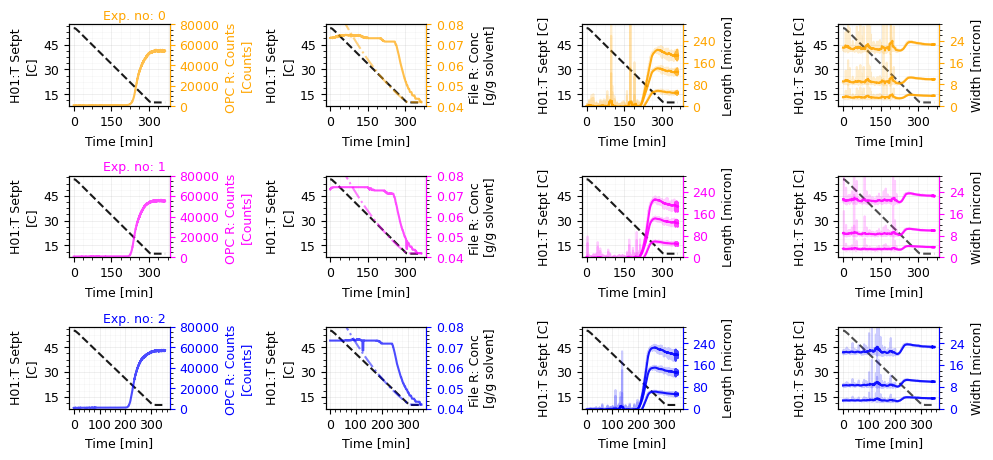

In [471]:
R.data_reader()
R.plot_generator()

In [430]:
# NEXT CHAPTER

In [433]:
#from scipy.io import loadmat
#from scipy.io import savemat


#data = loadmat(r"C:\Users\user\12. OMNIBUS-IMED integration\2025_12_10_init_models.mat", squeeze_me=True, struct_as_record=True)
#savemat(r"C:\Users\user\modified.mat", data, do_compression=False)
#data

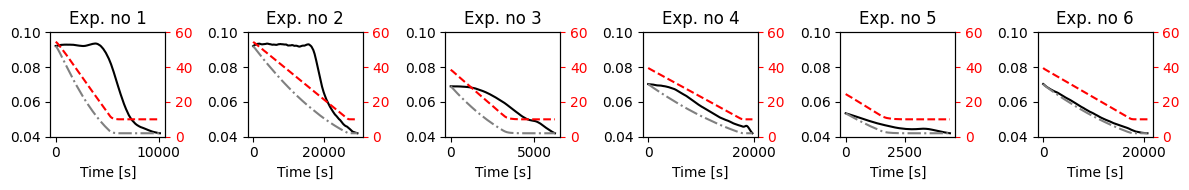

In [109]:
#fig, ax = plt.subplots(1,data['No'],figsize=(12,2) )
#for i in range(data['No']):
    
    #ax[i].plot(data['ExpData'][i][0][0],data['ExpData'][i][0][1],label='c',color='black')
    #ax[i].plot(data['ExpData'][i][4][0],solub(data['ExpData'][i][4][1]),'-.',label='sol',color='grey')
    #ax[i].set_xlabel("Time [s]")
    #ax[i].set_ylim([0.04,0.1])
    #ax[i].set_title(f'Exp. no {i+1:.0f}')
    #axT = ax[i].twinx()
    #axT.plot(data['ExpData'][i][4][0],data['ExpData'][i][4][1],'--',color='red',label='T')
    #axT.yaxis.label.set_color('red')
    #axT.tick_params(axis='y', colors='red')
    #axT.set_ylim([0,60])
    
#fig.tight_layout()